In [54]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

#import torch
import matplotlib.pyplot as plt


In [55]:
def combine_gaze_data(root_path="GazeBase_v2_0/Round_1"):
    combined_df = []

    subjects = os.listdir(root_path)
    count = 0
    for subject in subjects:
        try:
            sub_number = subject.split("_")[1]
            file_path = os.path.join(root_path, subject, "S1", "S1_Random_Saccades", f"S_{sub_number}_S1_RAN.csv")

            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df['subject_id'] = sub_number  # Add ID column
                df = df[df['x'].notna()]
                combined_df.append(df)
                count+=1
            else:
                print(f"Missing file for {subject}")
        except Exception as e:
            print(f"Error processing {subject}: {e}")
        if count >= 20:
            break

    all_data = pd.concat(combined_df, ignore_index=True)
    return all_data


In [56]:
df = combine_gaze_data()

In [57]:
df[['vel_x', 'vel_y']] = df.groupby('subject_id')[['x', 'y']].diff() * 1000


In [58]:
df

,n,x,y,val,xT,yT,dP,lab,subject_id,vel_x,vel_y
0,0,-14.968971,5.085097,0,0.308613,-0.376361,2993.0,0,1201,NaN,NaN
1,1,-14.971714,5.079250,0,0.308613,-0.376361,2992.0,0,1201,-2.743,-5.847
2,2,-14.974457,5.076327,0,0.308613,-0.376361,2990.0,0,1201,-2.743,-2.923
3,3,-14.968971,5.073403,0,0.308613,-0.376361,2990.0,0,1201,5.486,-2.924
4,4,-14.960741,5.073403,0,0.308613,-0.376361,2992.0,0,1201,8.230,0.000
...,...,...,...,...,...,...,...,...,...,...,...
1980693,101073,1.422280,0.180548,0,0.308613,-0.376361,3848.0,1,1044,2.937,-8.840
1980694,101074,1.419343,0.174655,0,0.308613,-0.376361,3849.0,1,1044,-2.937,-5.893
1980695,101075,1.413468,0.165815,0,0.308613,-0.376361,3850.0,1,1044,-5.875,-8.840
1980696,101076,1.401718,0.159922,0,0.308613,-0.376361,3851.0,1,1044,-11.750,-5.893


In [59]:
def split_subjects(df):
    subject_ids = df['subject_id'].unique()
    train_ids, temp_ids = train_test_split(subject_ids, test_size=0.3)
    print(temp_ids)
    val_ids, test_ids = train_test_split(temp_ids, test_size=1/3,)
    return train_ids, val_ids, test_ids

In [158]:
def split_by_saccades(df):
    inputs = []
    targets = []

    for subject_id, group in df.groupby('subject_id'):
        group = group.reset_index(drop=True)

        positions = group[['x', 'y']].to_numpy()
        labels = group['lab'].to_numpy()
        in_saccade = False
        start_idx = 0
        for i in range(1, len(group)):
            if labels[i] == 2 and not in_saccade:
                # Saccade starts
                in_saccade = True
                start_idx = i
            elif labels[i] != 2 and in_saccade:
                end_idx = i
                in_saccade = False

                if end_idx - start_idx > 1:
                    pos_window = positions[start_idx:end_idx-20:10] # (T, 2)
                    
                    landing_pos = positions[end_idx - 1]        # (2,)
                    inputs.append(pos_window)
                    targets.append(landing_pos)

    return np.array(inputs, dtype=object), np.array(targets)


In [159]:
saccades, targets = split_by_saccades(df)

In [160]:
len(saccades)

4285

In [161]:
len(targets)

4285

In [162]:
len(saccades[7])

4

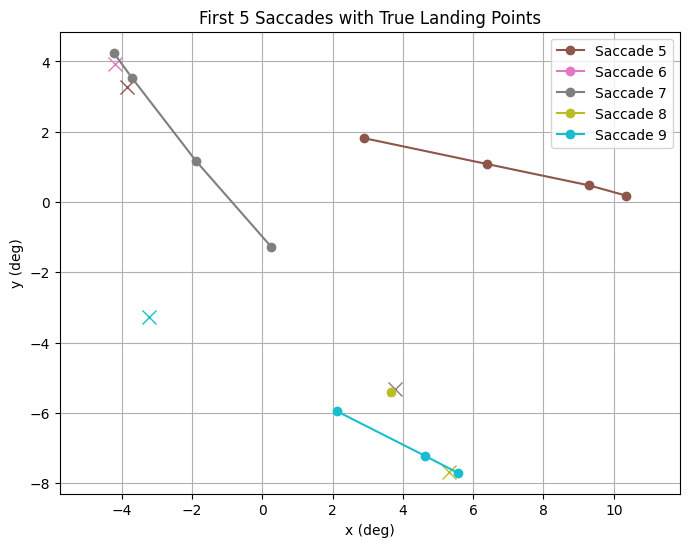

In [163]:
colors = plt.cm.tab10.colors

plt.figure(figsize=(8, 6))

for i in range(5,10):
    saccade = saccades[i]
    target = targets[i]

    x, y = saccade[:, 0], saccade[:, 1]

    plt.plot(x, y, marker='o', color=colors[i % 10], label=f'Saccade {i}')
    plt.plot(target[0], target[1], marker='x', color=colors[i % 10], markersize=10, linestyle='None')

plt.xlabel('x (deg)')
plt.ylabel('y (deg)')
plt.title('First 5 Saccades with True Landing Points')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


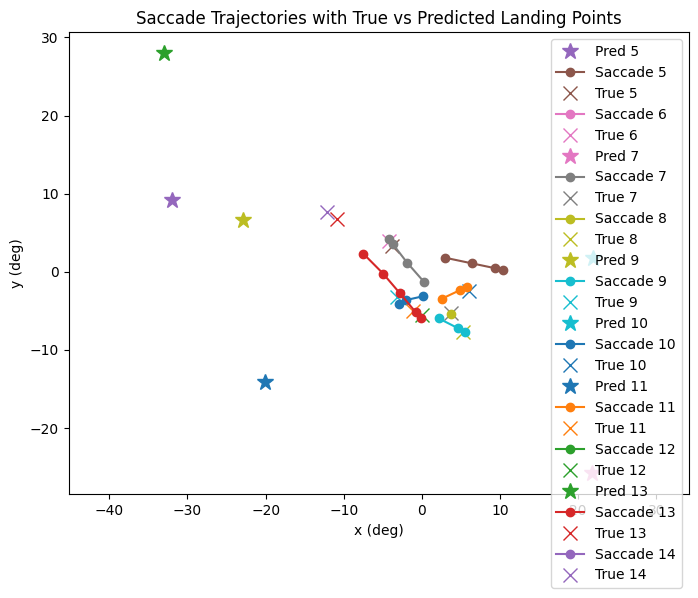

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define compressed exponential model
def compressed_exp(t, A, B, C, D):
    exponent = -B * (t**C)
    exponent = np.clip(exponent, -100, 100)  # prevents overflow in exp
    return A * (1 - np.exp(exponent)) + D


# Predict landing points using exponential fit
def predict_landing_point(saccade):
    T = saccade.shape[0]
    t = np.arange(1, T + 1)  
    x = saccade[:, 0]
    y = saccade[:, 1]

    try:
        popt_x, _ = curve_fit(compressed_exp, t, x, maxfev=10000)
        pred_x = compressed_exp(T - 1, *popt_x)
    except Exception:
        return None

    try:
        popt_y, _ = curve_fit(compressed_exp, t, y, maxfev=10000)
        pred_y = compressed_exp(T - 1, *popt_y)
    except Exception:
        return None

    return np.array([pred_x, pred_y])

def predict_landing_point_linear(saccade, predict_steps=10):
    """
    Predict saccade landing point by linear extrapolation from last velocity.

    Args:
        saccade (np.array): shape (T, 2) array of (x, y) positions
        predict_steps (int): number of steps to extrapolate forward (can tune)

    Returns:
        np.array: predicted landing (x, y)
    """
    if saccade.shape[0] < 2:
        return None  # Not enough points, return last position

    # Estimate velocity as difference of last two points
    velocity = saccade[-1] - saccade[-2]

    # Extrapolate forward by predict_steps using that velocity
    predicted_landing = saccade[-1] + velocity * predict_steps

    return predicted_landing


# Plotting first N saccades
N = 5
colors = plt.cm.tab10.colors
plt.figure(figsize=(8, 6))

for i in range(5,15):
    saccade = saccades[i]
    true_target = targets[i]
    predicted_target = predict_landing_point_linear(saccade)
    if predicted_target is not None:
        plt.plot(predicted_target[0], predicted_target[1], '*', color=color, markersize=12, label=f'Pred {i}')

    x, y = saccade[:, 0], saccade[:, 1]
    color = colors[i % 10]

    plt.plot(x, y, marker='o', color=color, label=f'Saccade {i}')
    plt.plot(true_target[0], true_target[1], 'x', color=color, markersize=10, label=f'True {i}')

plt.xlabel('x (deg)')
plt.ylabel('y (deg)')
plt.title('Saccade Trajectories with True vs Predicted Landing Points')
plt.axis('equal')
plt.legend()
plt.show()



In [170]:
def pred_error(true_pos, pred_pos):
    return np.linalg.norm(true_pos - pred_pos)


def mean_error(saccades):
    error_exp = []
    error_lin = []
    
    for i in range(len(saccades)):
        saccade = saccades[i]
        target = targets[i]
        
        pred_exp = predict_landing_point(saccade)
        if pred_exp is not None:
            error_exp.append(pred_error(target, pred_exp))
        pred_lin = predict_landing_point_linear(saccade)
        if pred_lin is not None:
            error_lin.append(pred_error(target, pred_lin))
    return sum(error_exp)/len(error_exp), sum(error_lin)/len(error_lin), error_lin, error_exp
    

In [171]:
a = mean_error(saccades) 


/tmp/ipykernel_7294/40945715.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_x, _ = curve_fit(compressed_exp, t, x, maxfev=10000)
/tmp/ipykernel_7294/40945715.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_y, _ = curve_fit(compressed_exp, t, y, maxfev=10000)
/tmp/ipykernel_7294/40945715.py:7: RuntimeWarning: overflow encountered in power
  exponent = -B * (t**C)


In [172]:
print("Mean error:" , a[0])

Mean error: 8.502238304804106
